#### Thanks to:
- Amira Adel Foda (intake 42 - smart village branch - group 2)
- Asmaa Said (intake 42 - smart village branch - group 2)
- Marawan Mohamed (intake 42 - Alex. branch - group 2)


### Installing MediaPipe

In [1]:
%%capture
!pip install mediapipe

### Unzipping Data 

In [100]:
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
    !gdown --id 1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
    !unzip /content/AFLW2000-3D.zip 

'gdown' is not recognized as an internal or external command,
operable program or batch file.
unzip:  cannot find or open /content/AFLW2000-3D.zip, /content/AFLW2000-3D.zip.zip or /content/AFLW2000-3D.zip.ZIP.


### Required Libraries

In [1]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
# I am commenting this as I am working in jupyter notebook
#from google.colab.patches import cv2_imshow

#Importing necessary libraries
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import glob

### Dowlining Data

In [2]:
# link of the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

### Preparing  Data

In [5]:
#Start processing data 
x_points= []
y_points = []
labels = []
detected_files = []

# extracting the file names (2000 name)
file_names = sorted([Path(f).stem for f in glob.glob("AFLW2000/*.mat")])

# detecting faces and extracting the points
faceModule = mediapipe.solutions.face_mesh
# looping over the file names to load the images and their corresponding mat file
for filename in file_names:
   with faceModule.FaceMesh(static_image_mode=True) as faces:
     # loading the image
     image = cv2.imread('AFLW2000/'+filename+'.jpg')
     # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
     results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
     if results.multi_face_landmarks != None:
          # appending the file names where have been detected.
          detected_files.append(filename)
          # detecting the face
          face = results.multi_face_landmarks[0]
          # initializing two lists to store the points for the image.
          X = []
          Y = []
          # looping over the 468 points of x and y
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image.
              shape = image.shape
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # X_features
              X.append(relative_x)
              # Y_features
              Y.append(relative_y)

          # converting the lists to numpy arrays
          X = np.array(X)
          Y = np.array(Y)
          # appending the points of the images in the list of all image points
          x_points.append(X)
          y_points.append(Y)

          # loading the mat file to extract the labels (pitch,yaw,roll)
          mat_file = sio.loadmat('AFLW2000/'+filename+'.mat')
          # extracting the labels 3 angels
          pose_para = mat_file["Pose_Para"][0][:3]
          # appending the 3 angels to labels list
          labels.append(pose_para)

# converting features and labels to 2D array
x_points = np.array(x_points)
y_points = np.array(y_points)
labels = np.array(labels)

# the first label (pitch)
pitch_label = labels[:,0]
# the first label (yaw)
yaw_label = labels[:,1]
# the first label (roll)
roll_label = labels[:,2]


In [6]:
print(x_points.shape)
print(y_points.shape)
print(labels.shape)

(1853, 468)
(1853, 468)
(1853, 3)


In [88]:
# centering points to Nose point with index 5
x_center = x_points - x_points[:,5].reshape(-1,1)
y_center = y_points - y_points[:,5].reshape(-1,1)

# normalizing the data by dividing with farest point from nose in x and y directions 
Norm_x = x_center / np.max(np.abs(x_center),axis=1).reshape(-1,1)
Norm_y = y_center / np.max(np.abs(y_center),axis=1).reshape(-1,1)
final_x = Norm_x
final_y = Norm_y
# concatanting features 
features = np.hstack([final_x,final_y])

print(final_x.shape)
print(final_y.shape)
print(features.shape)

(1853, 468)
(1853, 468)
(1853, 936)


### Bulding the Model 

In [89]:
# split data to training and test Datasets 
X_train,X_val,y_train,y_val = train_test_split(features,labels,test_size = 0.2,random_state = 40)

In [90]:
# chossing SVR as best Model to work with 
svr_reg = MultiOutputRegressor(SVR(kernel='rbf',C=5,gamma=0.01,degree=10,epsilon=0.001))
svr_reg.fit(X_train,y_train)


MultiOutputRegressor(estimator=SVR(C=5, degree=10, epsilon=0.001, gamma=0.01))

In [91]:
#testing model with validation Data 
#print("Train acc: ", svr_reg.score(X_train,y_train))
print("Validation acc: ",svr_reg.score(X_val,y_val))

Validation acc:  0.8572318267865994


### Bulding functions to run the model on real data

In [93]:
# functiion to draw axis on image 
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

### Preparing Data

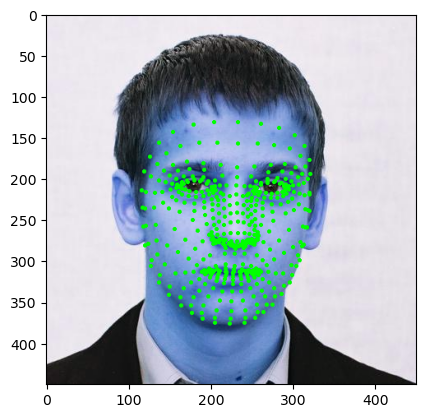

In [94]:
# choosing random image
random_file = 'image00053'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None:
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      plt.imshow(image)

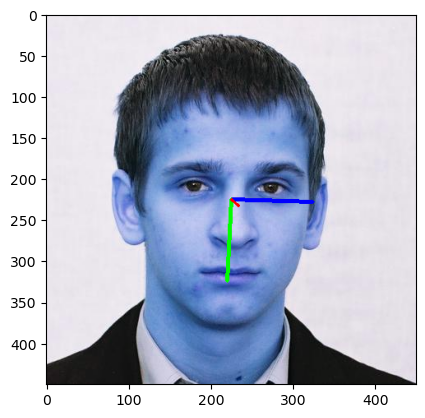

In [95]:
image = cv2.imread('AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
plt.imshow(draw_axis(image,pitch,yaw,roll))

In [58]:
# extracting landmarks from image 
def extract_landmarks(image):
    x_features = []
    y_features = []
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None: 
            for face in results.multi_face_landmarks:
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    shape = image.shape 
                    x_features.append(x*shape[1])
                    y_features.append(y*shape[0])
                    # cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
    if x_features:
        x_features=np.array(x_features)
        y_features=np.array(y_features)
        img_features2=np.hstack([x_features,y_features])
        x_center=x_features-x_features[5]
        y_center=y_features-y_features[5]
        Norm_x = x_center / np.max(np.abs(x_center))
        Norm_y = y_center / np.max(np.abs(y_center))
        final_x = Norm_x
        final_y = Norm_y
        features = np.hstack([final_x,final_y])
    else:
        features=[]
        img_features2=[]
    return features , x_features,y_features


In [96]:
def predict_pose(image, model):
    img_features,x_features,y_features = extract_landmarks(image)
    if image.shape == (0,) or len(img_features) == 0:
        return None,None,None
    img_features = img_features.reshape(1,-1)
    return model.predict(img_features), x_features , y_features

In [97]:
#function to apply Head pose Estimation on Some videos 
def apply_on_video(video_path):
    #video_path = 'new_mad5.mp4'
    cap = cv2.VideoCapture(video_path)
    new_path="new_videos\\"+str(video_path.split("\\")[-1])
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    out = cv2.VideoWriter(new_path,cv2.VideoWriter_fourcc('X','V','I','D'), 30, (frame_width,frame_height))
    video_clip = VideoFileClip(video_path)
    audio_clip = video_clip.audio

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        pose , x_features,y_features = predict_pose(frame, svr_reg) or (None,None)
        if pose is not None:
            pitch, yaw, roll = pose[0]
            draw_axis(frame, pitch, yaw,roll,tdx=x_features[5],tdy=y_features[5] ,size = 100)
        out.write(frame)
    temp_audio_path = new_path.replace('.mp4', '.mp3')
    audio_clip.write_audiofile(temp_audio_path)
    out.release()
    cv2.destroyAllWindows()
    # Path to the audio file (MP3)
    audio_path = new_path.replace('.mp4', '.mp3')

    # Load the video clip and the audio clip
    video_clip = VideoFileClip(new_path)
    audio_clip = AudioFileClip(audio_path)

    # Set the audio of the video clip to the audio clip
    video_clip = video_clip.set_audio(audio_clip)

    # Write the video clip with audio to a new file
    video_clip.write_videofile(new_path.replace("_n","_nnnnn"), codec='libx264', audio_codec='aac')
    if os.path.exists(new_path):
        os.remove(new_path)
    if os.path.exists(audio_path):
        os.remove(audio_path)

        
    

In [98]:
# applying Head pose Estimation on Some videos from original_videos folder
folder_path = 'original_videos/*.mp4'
video_paths = glob.glob(folder_path)

for video_path in video_paths[0:5]:
    apply_on_video(video_path)
    print(video_path)

MoviePy - Writing audio in new_videos\408439840_1493580371209989_4466838599607657145_n.mp3


MoviePy - Done.
Moviepy - Building video new_videos\408439840_1493580371209989_4466838599607657145_nnnnn.mp4.
MoviePy - Writing audio in 408439840_1493580371209989_4466838599607657145_nnnnnTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video new_videos\408439840_1493580371209989_4466838599607657145_nnnnn.mp4



Moviepy - Done !
Moviepy - video ready new_videos\408439840_1493580371209989_4466838599607657145_nnnnn.mp4
original_videos\408439840_1493580371209989_4466838599607657145_n.mp4
MoviePy - Writing audio in new_videos\423339594_901833808340052_7419339554459810834_n.mp3


MoviePy - Done.
Moviepy - Building video new_videos\423339594_901833808340052_7419339554459810834_nnnnn.mp4.
MoviePy - Writing audio in 423339594_901833808340052_7419339554459810834_nnnnnTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video new_videos\423339594_901833808340052_7419339554459810834_nnnnn.mp4



Moviepy - Done !
Moviepy - video ready new_videos\423339594_901833808340052_7419339554459810834_nnnnn.mp4
original_videos\423339594_901833808340052_7419339554459810834_n.mp4
MoviePy - Writing audio in new_videos\424596286_1612436822895496_4765915555570329435_n.mp3


MoviePy - Done.
Moviepy - Building video new_videos\424596286_1612436822895496_4765915555570329435_nnnnn.mp4.
MoviePy - Writing audio in 424596286_1612436822895496_4765915555570329435_nnnnnTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video new_videos\424596286_1612436822895496_4765915555570329435_nnnnn.mp4



Moviepy - Done !
Moviepy - video ready new_videos\424596286_1612436822895496_4765915555570329435_nnnnn.mp4
original_videos\424596286_1612436822895496_4765915555570329435_n.mp4
MoviePy - Writing audio in new_videos\424614856_366836122762179_814216936483661199_n.mp3


MoviePy - Done.
Moviepy - Building video new_videos\424614856_366836122762179_814216936483661199_nnnnn.mp4.
MoviePy - Writing audio in 424614856_366836122762179_814216936483661199_nnnnnTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video new_videos\424614856_366836122762179_814216936483661199_nnnnn.mp4



Moviepy - Done !
Moviepy - video ready new_videos\424614856_366836122762179_814216936483661199_nnnnn.mp4
original_videos\424614856_366836122762179_814216936483661199_n.mp4
MoviePy - Writing audio in new_videos\429589973_236034026170159_2481890116192714095_n.mp3


MoviePy - Done.
Moviepy - Building video new_videos\429589973_236034026170159_2481890116192714095_nnnnn.mp4.
MoviePy - Writing audio in 429589973_236034026170159_2481890116192714095_nnnnnTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video new_videos\429589973_236034026170159_2481890116192714095_nnnnn.mp4



Moviepy - Done !
Moviepy - video ready new_videos\429589973_236034026170159_2481890116192714095_nnnnn.mp4
original_videos\429589973_236034026170159_2481890116192714095_n.mp4


In [105]:
# function to apply the model with camera 
def apply_on_video_camera():
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not open camera.")
        return

    new_path = "new_videos\\my_own_video.mp4"
    print("new_path", new_path)

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create a VideoWriter object
    out = cv2.VideoWriter(new_path, cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        pose, x_features, y_features = predict_pose(frame, svr_reg) or (None, None)
        if pose is not None:
            pitch, yaw, roll = pose[0]
            draw_axis(frame, pitch, yaw, roll, tdx=x_features[5], tdy=y_features[5], size=100)
        cv2.imshow('Camera Feed', frame)
        out.write(frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to quit
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

apply_on_video_camera()


new_path new_videos\my_own_video.mp4


In [106]:
apply_on_video_camera()

new_path new_videos\my_own_video.mp4
